In [1]:
import sys; sys.path.append('..')
from about_time import about_time  # ❯ pip install about-time

from brain.sdk import BrainClient

In [2]:
brain = BrainClient("http://127.0.0.1:8000")

# Basic Usage

**Reasoner** 
- Systems that analyze input and provide meaningful output.
- Use the `@reasoner` decorator on a Python function that returns a system prompt and user prompt.
- Responses are formatted according to the attached schema.

In [3]:
from pydantic import BaseModel, Field


class AnswerSchema(BaseModel):
    answer:str
    explanation:str


# Attach tags or pass optional name to the reasoner
@brain.reasoner(name="Sample Reasoner",schema=AnswerSchema,tags=["sample","quick-start"])
def sample_reasoner(system_prompt, user_prompt):
    return dict(system_prompt=system_prompt, user_prompt=user_prompt)

brain.list_reasoners()

                                Reasoners in Project: Default Project                                 
                                                                                                      
  Reasoner          ID                                     Tags                      Created At       
 ──────────────────────────────────────────────────────────────────────────────────────────────────── 
  Sample Reasoner   778e682c-1653-4bd2-854a-eb9d844e57f5   sample, quick-start   2024-12-03 03:14:53  
                                                                                                      
  foo               f7132eac-27eb-40f0-bae5-90a89d81aac6                         2024-12-03 03:14:50  
                                                                                                      
  foo               72b046bd-8053-4dc9-833e-380ea3928597                         2024-12-03 03:14:50  
                                                                                                      
  foo               1049fa58-a281-42f5-91f8-48af2bcbf135                         2024-12-03 03:14:47  
                                                                                                      
  foo               d6290189-d78d-40b1-9335-33289ed7569b                         2024-12-03 03:14:47

We run the reasoner via their ID, this is so that we can swap out the implementation of the reasoner without changing the code that uses it in real-time.

In [4]:
question = "How many R's are there in the word 'STRAWBERRY'?"

with about_time() as t_sync:
    answer_sync = brain.use(sample_reasoner.id)(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    )
    
with about_time() as t_async:
    fut=[]
    for _ in range(5):
        fut.append(brain.use(sample_reasoner.id,run_async=True)(
            system_prompt="You are an expert letter counter, answer this question",
            user_prompt=question,
        ))
    answer_async = [f.result() for f in fut]
    

print("\033[4m1 synchronous call\033[0m")
print(f"Time Taken: {t_sync.duration_human}")
print(f"Answer: {answer_sync}")
print("\n" + "-" * 50 + "\n")
print("\033[4m5 asynchronous calls\033[0m")
print(f"Total Time Taken for 5 async calls: {t_async.duration_human}")
for idx, ans in enumerate(answer_async, start=1):
    print(f"{idx}. Answer: {ans}")

1 synchronous call
Time Taken: 818.1ms
Answer: answer='2' explanation="The word 'STRAWBERRY' contains two instances of the letter 'R'."

--------------------------------------------------

5 asynchronous calls
Total Time Taken for 5 async calls: 680.6ms
1. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two instances of the letter 'R'."
2. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."
3. Answer: answer='2' explanation="In the word 'STRAWBERRY', there are two occurrences of the letter 'R'."
4. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two 'R's. They appear as the fifth and sixth letters in the word."
5. Answer: answer='2' explanation="The word 'STRAWBERRY' contains two occurrences of the letter 'R'."


## Multiagents

- Encapsulate multiple reasoners.
- Combine outputs of multiple reasoners into a single workflow.
- Do not have a schema.
- Decorated with the `@multi_agent` decorator.
- Define complex units of work requiring multiple specialized reasoners.

### The story writer

In [11]:
from typing import List

from pydantic import BaseModel, Field


# Define schemas for reasoners
class Story(BaseModel):
    story_next_lines: str = Field(..., description="Continuation of the story. Do not repeat the story in the prompt, just provide the continuation.")

class Character(BaseModel):
    name: str = Field(..., description="The name of the character.")
    description: str = Field(..., description="The detailed description of the character and their role in the story.")

class Action(BaseModel):
    type: str = Field(..., description=f"The type of action to take. One of given actions.")
    action_description: str = Field(..., description="suggested continuation or action for the story.")

# Define reasoners
@brain.reasoner(schema=Story)
def story_extender(story: str, action: str):
    """Extends the story based on the provided action."""
    system_prompt = "You are a skilled storyteller."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Based on the action '{action}', give a short (~1-3 lines) continuation to the story. If the action is 'end_story', conclude the story gracefully."
    )
    return user_prompt, system_prompt

@brain.reasoner(schema=Character)
def character_describer(name: str, story: str):
    """Introduces a character based on the current story context."""
    system_prompt = "You are a creative writer."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Introduce the character named {name} into the story. Use their personality and traits to make their role meaningful."
    )
    return user_prompt, system_prompt

@brain.reasoner(schema=Action)
def action_extender(story: str, actions: List[str]):
    """Suggests the next action for the story."""
    system_prompt = "You are a narrative strategist."
    user_prompt = (
        f"The current story is:\n{story}\n"
        f"Suggest the next action for the story.Based on existing story, choose one of the following that would be the best next step"
        f"\nActions:{actions+['introduce character']}."
        "Clearly state the action type and provide the next_action description."
    )
    return user_prompt, system_prompt

Let's define the multiagent that will use all these reasoners above to generate an interesting story

In [12]:
from random import choice
from typing import List


@brain.multi_agent(name="Story Builder", tags=["storytelling","quick-start"])
def story_builder(start: str, characters: List[str],actions=List[str], n: int = 5):
    """
    Builds a story iteratively by introducing characters and progressing actions.

    Args:
        start (str): The starting line of the story.
        characters (List[str]): List of character names to introduce dynamically.
        n (int): Maximum number of iterations to build the story.

    Returns:
        dict: The final story, introduced characters, remaining characters, and final action.
    """
    story = start
    introduced_characters = []  # Track introduced characters
    remaining_characters = characters[:]  # Characters not yet introduced
    actions_proposed=[]
    
    for _ in range(n-1):
        # Step 1: Determine the next action
        action = brain.use(action_extender.id)(story=story,actions=actions)
        actions_proposed.append(action)
        
        if action.type == "introduce character" and remaining_characters:
            # Introduce a random character
            character_name = choice(remaining_characters)
            
            remaining_characters.remove(character_name)
            character_description = brain.use(character_describer.id)(name=character_name, story=story).description
            story += brain.use(story_extender.id)(story=story, action=f"Introduce {character_name}: {character_description}").story_next_lines
            introduced_characters.append(character_name)

        else:
            story += brain.use(story_extender.id)(story=story, action=f"Type:{action.type} Descprition{action.action_description}").story_next_lines
            

    # Conclude the story
    story += brain.use(story_extender.id)(story=story, action="end_story").story_next_lines

    # Return the final result
    return {
        "final_story": story,
        "introduced_characters": introduced_characters,
        "remaining_characters": remaining_characters,
        "final_action": actions_proposed,
    }

In [13]:
from rich import print

start="Once upon a time, in a faraway land "
characters=["Alice", "Bob", "Charlie", "David", "Eve"]
action=['add happy emotion', 'add sad emotion', 'add twist','make it magical','add fight']
n=6

story=story_builder(start, characters,actions=action, n=n)

print(story)

{
    'final_story': 'Once upon a time, in a faraway land As Bob stepped through the shimmering portal, he felt a 
rush of energy and wonder, revealing a vibrant world filled with mystical creatures and radiant landscapes. Little 
did he know, the prophecy he sought was drawn to his hopeful spirit, and dark forces were already aware of his 
arrival.Eve approached Bob with a bright smile, her hair shimmering in the sunlight as she extended her hand in 
friendship. "Welcome, traveler! Together, we can uncover the secrets of this realm and protect it from the looming 
darkness." With a newfound determination, Bob took her hand, feeling the warmth of her spirit fueling his own 
courage.As the forest spirits swirled around them, one with twinkling eyes stepped forward, whispering ancient 
secrets that led them to a hidden glen. "The heart of this world lies ahead," it said, "but beware, for shadows 
lurk in the depths, ready to challenge the light you carry within." With courage ignited, Bob and Eve ventured 
forth, ready to confront the darkness.The blast of light from the crystal cut through the shadows, creating a 
barrier that momentarily stalled the advancing darkness. Empowered by their bond and determination, Bob and Eve 
fought back with ferocity, each blow fueled by the strength of hope, as they began to turn the tide of battle in 
their favor.As the Shadow Guardian emerged, its voice resonated like thunder, echoing with lost hope. "You think 
you can restore what was lost?" it challenged, its eyes glowing with malevolence. Bob and Eve exchanged glances, 
realizing that to defeat the Guardian, they must not only fight for their realm but also awaken the light hidden 
deep within its twisted heart.Summoning their inner strength, Bob and Eve channeled their unwavering hope, weaving 
a tapestry of light that enveloped the Shadow Guardian. With a final, blinding surge, the darkness shattered, 
revealing the Guardian\'s true form—a once-pure spirit longing for redemption. Together, they embraced the power of
forgiveness, restoring balance to the realm and ensuring that light would forever triumph over darkness.',
    'introduced_characters': ['Bob', 'Eve'],
    'remaining_characters': ['Alice', 'Charlie', 'David'],
    'final_action': [
        Action(
            type='introduce character',
            action_description='Introduce a brave young princess named Elara, who dreams of exploring the enchanted
forest that borders her kingdom, filled with mysterious creatures and ancient secrets.'
        ),
        Action(
            type='introduce character',
            action_description="As Bob takes in the majestic surroundings, he is approached by a wise old wizard 
named Eldrin, who senses the strong magic within Bob and reveals that he has been expecting him. Eldrin explains 
the importance of Bob's quest and the dangers that lie ahead."
        ),
        Action(
            type='make it magical',
            action_description='As Bob and Eve journey deeper into the vibrant world, they discover an ancient 
grove where the trees shimmer with iridescent leaves. Suddenly, a gentle breeze stirs, revealing playful forest 
spirits who dance around them, casting spells of protection and guiding them towards their destiny. The air fills 
with laughter and light, making Bob and Eve feel as if they are part of a grand tapestry of magic that connects all
living things.'
        ),
        Action(
            type='add fight',
            action_description='As Bob and Eve approached the heart of the world, the air grew thick with a 
malevolent energy. Suddenly, shadowy figures emerged from the darkness, their forms shifting and twisting as they 
screeched and lunged at the duo. Bob, clutching a glowing crystal gifted by the forest spirits, prepared to defend 
Eve. With a furious battle cry, he unleashed the energy of the crystal, lighting up the glen and igniting an epic 
confrontation against the dark forces.'
        ),
        

In [14]:
runs=brain.list_runs(return_data=True)

                                   MultiAgent Session Runs in Project: Default Project                                    
                                                                                                                          
  Session ID                              MultiAgent     Reasoner Calls          Start Date & Time    Total Duration (s)  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  6c7fec53-69b3-436a-b071-8e78411e06f2   Story Builder   action_extender        2024-12-03 03:16:28         17.86         
                                                         (2.72s) →                                                        
                                                         character_describer                                              
                                                         (1.57s) →                                                        
                                                         story_extender                                                   
                                                         (0.76s) →                                                        
                                                         action_extender                                                  
                                                         (1.27s) →                                                        
                                                         character_describer                                              
                                                         (1.94s) →                                                        
                                                         story_extender                                                   
                                                         (1.23s) →                                                        
                                                         action_extender                                                  
                                                         (1.02s) →                                                        
                                                         story_extender                                                   
                                                         (1.02s) →                                                        
                                                         action_extender                                                  
                                                         (1.43s) →                                                        
                                                         story_extender                                                   
                                                         (0.98s) →                                                        
                                                         action_extender                                                  
                                                         (1.07s) →                                                        
                                                         story_extender                                                   
                                                         (1.02s) →                                                        
                                                         story_extender                                                   
                                                         (1.83s)                                                          
                                                                                                                          
  caee33da-fae4-4de0-afe8-d6bcbcaa801c   Story Builder   action_extender        2024-12-03 03:14:54         12.09         
                                                         (0.89s)

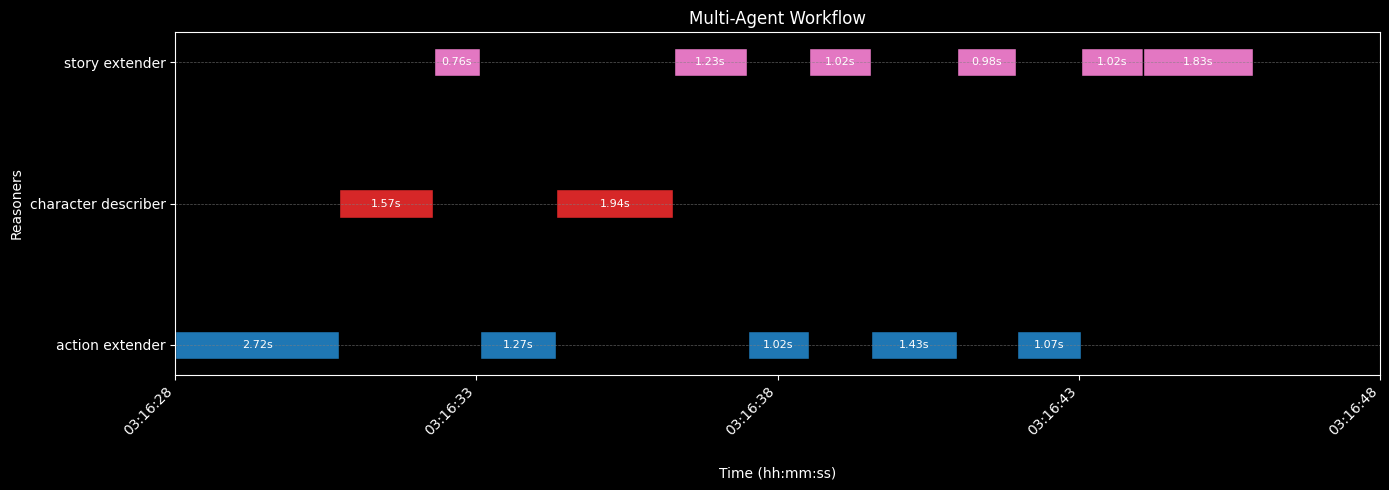

In [15]:
from brain.visualize import plot_workflow_matplotlib

lineage=brain.get_call_graph(runs[0]['session_id'])
fig=plot_workflow_matplotlib(lineage['lineage'])

## Modifiers

- Modifiers are objects that can be passed to modify the runtime behavior of the reasoner.
- Passed as keyword arguments when using the reasoner.
- Custom modifiers can be defined by inheriting from the `ModifierBase` class.
- Built-in modifiers include reasoning enhancers like CoT/IoT, guardrails, transformations, etc.

In [17]:
from brain.modifiers import COT as ChainOfThought

question = "How many R's are there in the word 'STRAWBERRY'?"
    
fut=[]
for _ in range(5):
    fut.append(brain.use(sample_reasoner.id,run_async=True)(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    ))
answer_wo_mod = [f.result().answer for f in fut]
    
fut=[]
for _ in range(5):
    fut.append(brain.use(sample_reasoner.id,run_async=True,modifier=ChainOfThought())(
        system_prompt="You are an expert letter counter, answer this question",
        user_prompt=question,
    ))
answer_w_mod = [f.result().answer for f in fut]

print(f"Question: {question}")
print(f"Answers without modifier : {answer_wo_mod}")
print(f"Answers with CoT modifier: {answer_w_mod}")

Question: How many R's are there in the word 'STRAWBERRY'?

Answers without modifier : ['2', '2', '2', '2', '2']

Answers with CoT modifier: ['3', '3', '3', '3', '2']